In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict/group-output-time_mod.csv
/kaggle/input/predict/wgan_new1000.h5
/kaggle/input/gp-layernormalization/wgan9000_gp_layernormlazition.h5


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time

import functools

**This part is for the prediction on one simulation using WGAP-GP.**

# Load data

In [3]:
def read_file(file):
    times=[]
    values=[]
    with open(file) as f:
        for line in f:
            if 'groups' in line:
                groups=line.replace(","," ").split()[5:]
            if 'TIME' in line:
                newtime = True
                break
                
        while newtime:
            newtime = False
            times.append(float(line.replace(',',' ').split()[2]))

            values_per_time = []
            for line in f:
                if 'GROUP' in line:
                    continue
                if 'TIME' in line:
                    newtime = True
                    break
                values_per_time.append([float(x) for x in line.strip().split(',') if x != ''])  
            values.append(values_per_time)
        return times, groups, values

In [4]:
times,groups,values=read_file('/kaggle/input/predict/group-output-time_mod.csv')

In [5]:
times=np.array(times)
values=np.array(values)

print("time num: ", times.shape)
print("group name: ", groups)
print("values shape: ", values.shape)

time num:  (3888,)
group name:  ['HOME-S', 'HOME-E', 'HOME-I', 'HOME-R', 'MOBILE-S', 'MOBILE-E', 'MOBILE-I', 'MOBILE-R']
values shape:  (3888, 80, 10)


In [6]:
nl = int(values.shape[-1])
nc = int(values.shape[-2]/len(groups))
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [7]:
X_train_2D=values
X_train_1D=X_train_2D.reshape(len(times),len(groups)*nl*nc)
print("uncompress data shape: ", X_train_1D.shape)

uncompress data shape:  (3888, 800)


In [8]:
# compress 800 variables to 15
from sklearn.decomposition import PCA

pca_compressed=PCA(n_components=15)
X_train_compressed=pca_compressed.fit_transform(X_train_1D)
X_recovered=pca_compressed.inverse_transform(X_train_compressed)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalize the data to [-1,1]
X_train_scaled = scaler.fit_transform(X_train_compressed)*2 -1
np.allclose(X_train_compressed, scaler.inverse_transform((X_train_scaled+1)/2))

True

In [10]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [11]:
codings_size = X_train_compressed.shape[1] #15
ntimes = 9 # Consecutive times for the GAN
step = 10 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )
print("concat data shape: ", X_train_concat.shape)

concat data shape:  (3798, 9, 15)


In [12]:
BATCH_SIZE = 256
latent_space = 100


In [ ]:
# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], 9, 15, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
num=0
for data in train_dataset:
    print("every time the data shape",data.shape)
    num+=1
#     print(data)
#     break

# Load trained model

In [18]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model("/kaggle/input/gp-layernormalization/wgan9000_gp_layernormlazition.h5").layers

In [19]:
gan = keras.models.Sequential([generator, discriminator])

# Predictions 

In [31]:
#weight = tf.constant(np.ones(15), dtype=tf.float32)
weight = tf.constant(pca_compressed.singular_values_, dtype=tf.float32)
#weight = tf.constant(pca_compress.explained_variance_, dtype=tf.float32)
weight

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([8.0968852e+04, 1.8736416e+04, 1.3673706e+04, 5.5826768e+03,
       3.8501030e+03, 1.8000193e+03, 1.5285522e+03, 1.2805509e+03,
       7.3294604e+02, 4.3526801e+02, 2.9716446e+02, 1.8160262e+02,
       8.7675873e+01, 6.4752045e+01, 5.6145763e+01], dtype=float32)>

In [32]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    return mse(inp, outp)

In [33]:
#@tf.function
def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [34]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1)
#     latent_values = tf.random.normal([len(real_coding), latent_size])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(1000):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
                            
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

### Timestep = 2000

In [35]:
n = 2000
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

Loss:  0.78019583
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[-5.29807284e-02, -1.17353335e-01,  7.50542209e-02,
         9.82469097e-02,  1.75667524e-01,  7.70469084e-02,
         1.42160967e-01,  1.17386602e-01,  1.75381884e-01,
        -4.21672724e-02, -1.23140484e-03,  2.07594007e-01,
        -1.67296365e-01,  1.83328360e-01,  5.18792048e-02,
        -5.91995381e-02,  1.98149219e-01, -2.65166581e-01,
         4.53459807e-02, -4.07302789e-02,  7.70495133e-03,
         1.07420690e-01,  1.15165286e-01,  9.77416709e-02,
        -1.88630685e-01,  1.51656449e-01, -2.28670195e-01,
         1.57032818e-01, -4.66759428e-02,  1.20686486e-01,
         1.32854894e-01, -7.42233098e-02, -1.10640571e-01,
         1.11143105e-01,  7.97013864e-02, -2.66482569e-02,
        -1.78625003e-01,  2.05266535e-01, -1.81709062e-02,
         7.86087587e-02, -1.75646991e-01,  1.61578089e-01,
         5.80111407e-02,  9.60066020e-02,  2.67295688e-01,
        -1.15269132e-01,  5.329043

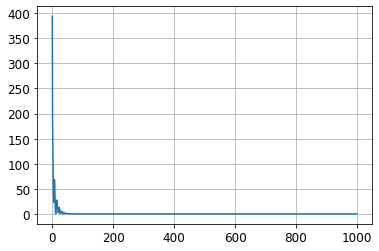

In [36]:
latent_size = 100
latent_values = optimize_coding(real_coding, weight)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())
print(latent_values)

In [37]:
X_generated = scaler.inverse_transform((generator.predict(tf.convert_to_tensor(latent_values)).reshape(ntimes,codings_size)+1)/2)
X_generated = pca_compressed.inverse_transform(X_generated)
X_generated = X_generated.reshape(ntimes, len(groups)*nl*nc)

In [38]:
X_real = scaler.inverse_transform((X_train_concat_flatten[n].reshape(ntimes,codings_size)+1)/2)
X_real = pca_compressed.inverse_transform(X_real)
X_real = X_real.reshape(ntimes, len(groups)*nl*nc)

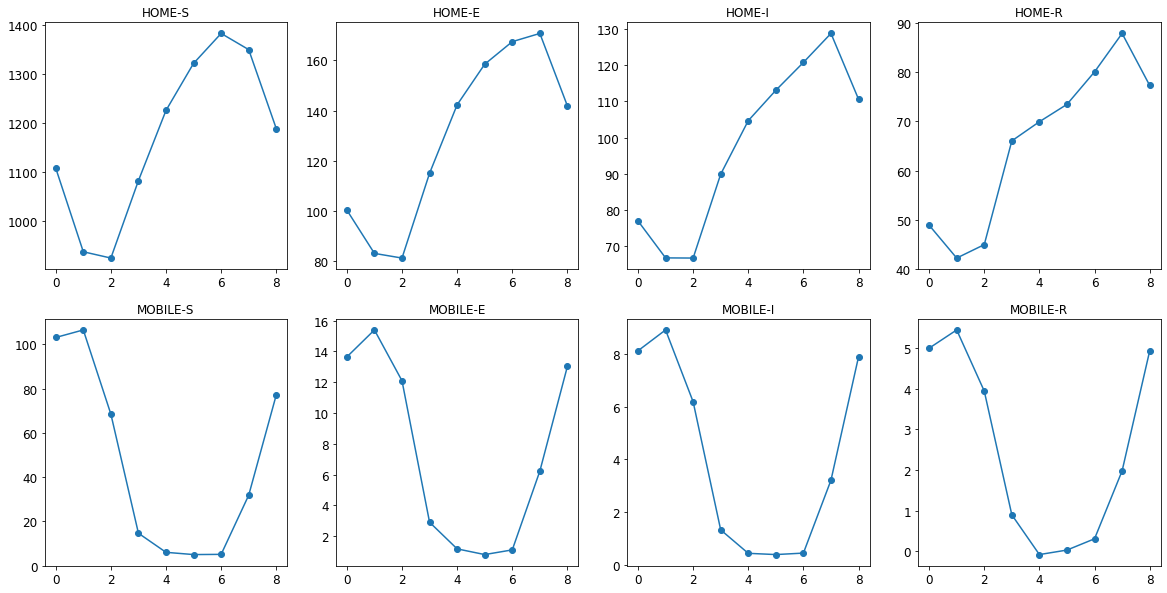

In [39]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata.png')

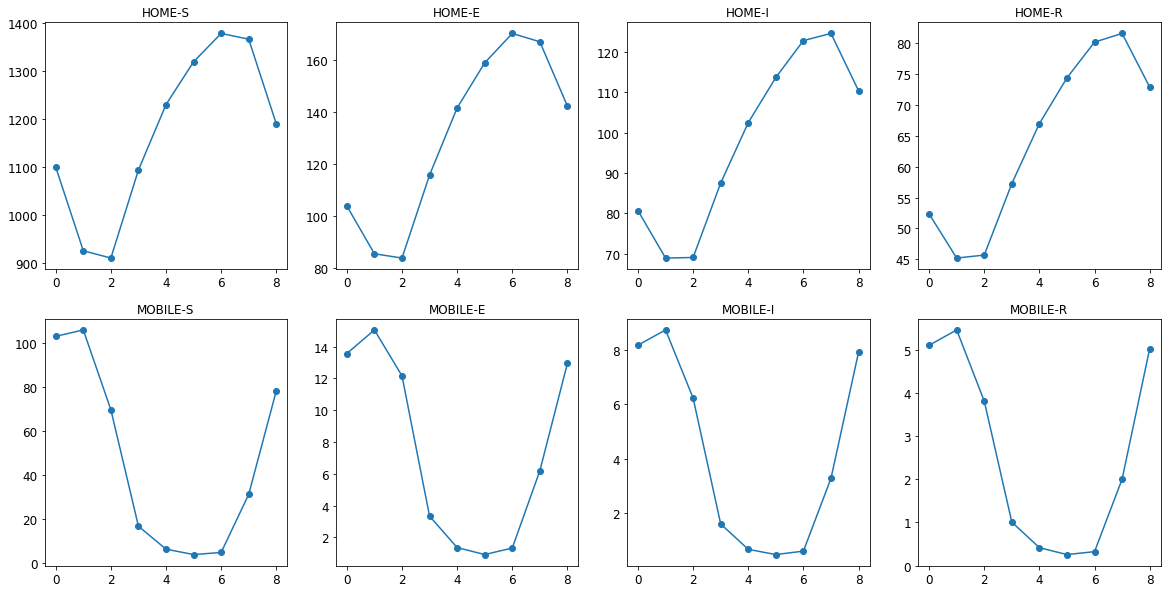

In [40]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_real[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)

In [41]:
def optimize_coding(latent_values, real_coding, loss_weight, epochs=1000):
    
    for epoch in range(epochs):
        opt_step(latent_values, real_coding, loss_weight)
        
    return latent_values  #returns the optimized input that generates the desired output

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

latent_size = 100
n = 2000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

# latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1)
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

# latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
# X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
# gen_predict = X_predict[-1]
# read_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:, codings_size:]
# real_coding = tf.constant(real_coding)
# real_coding = tf.cast(real_coding, dtype=tf.float32)

X_predict = list(X_train_concat[n,:-1])
for i in range(100): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [43]:
X_generated1 = scaler.inverse_transform((X_predict+1)/2)
X_generated1 = pca_compressed.inverse_transform(X_generated1)
X_generated1 = X_generated1.reshape(len(X_predict), len(groups)*nl*nc)
X_generated1[X_generated1<0] = 0 

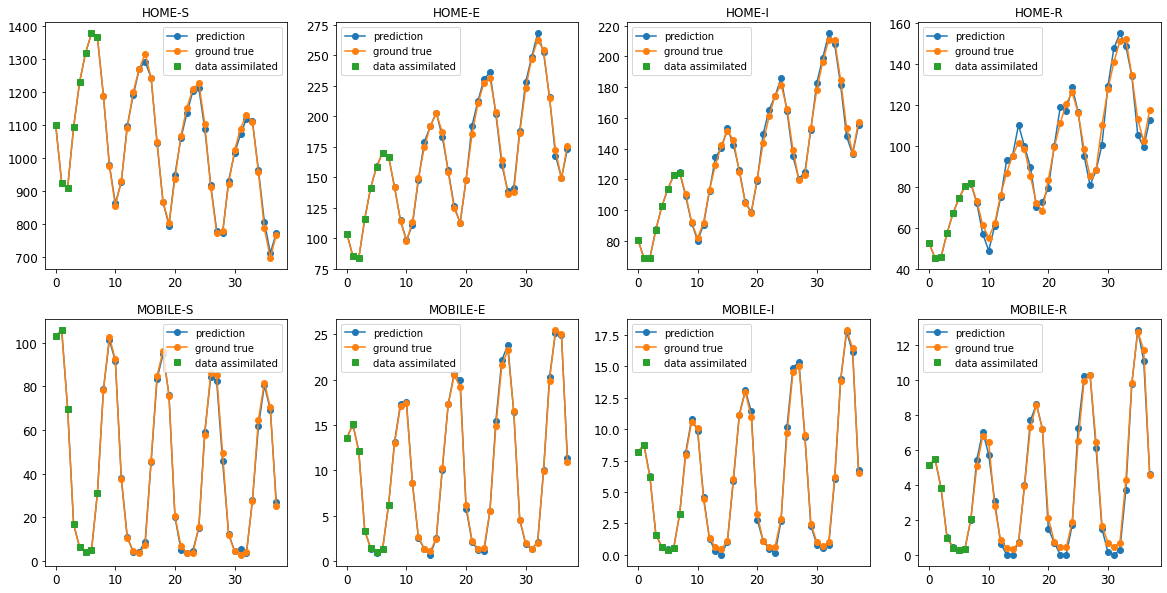

In [44]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated1[:8+30,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

**In final report, the above picture is Figure. 8**

### timestep = 1000

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

latent_size = 100
n = 1000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

# latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1)
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

# latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
# X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
# gen_predict = X_predict[-1]
# read_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:, codings_size:]
# real_coding = tf.constant(real_coding)
# real_coding = tf.cast(real_coding, dtype=tf.float32)

X_predict = list(X_train_concat[n,:-1])
for i in range(100): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [55]:
X_generated1 = scaler.inverse_transform((X_predict+1)/2)
X_generated1 = pca_compressed.inverse_transform(X_generated1)
X_generated1 = X_generated1.reshape(len(X_predict), len(groups)*nl*nc)
X_generated1[X_generated1<0] = 0 

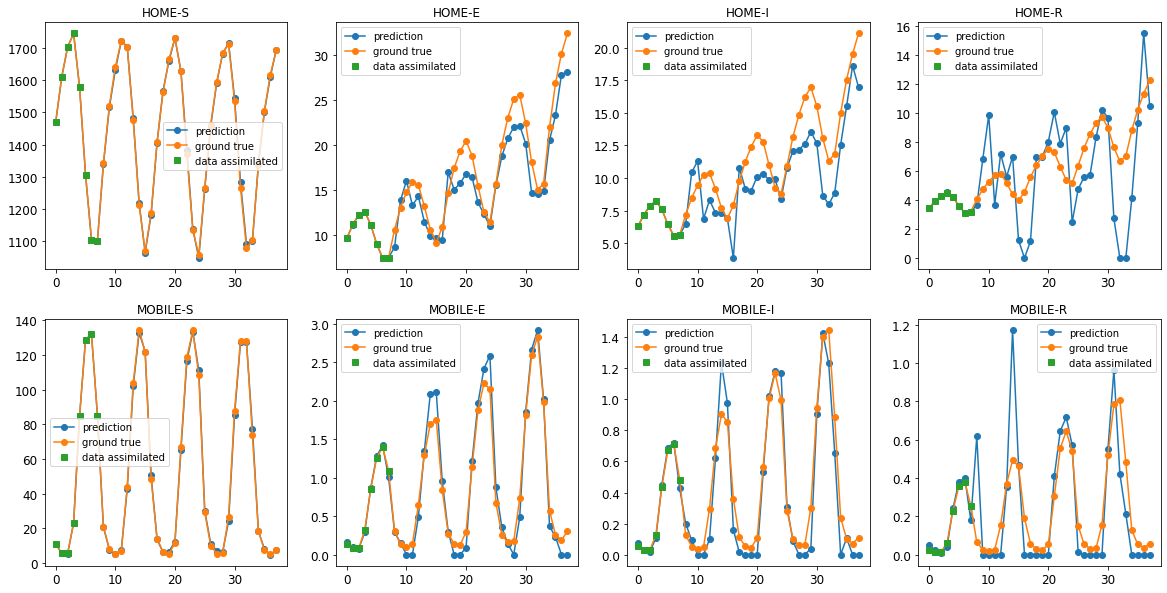

In [56]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated1[:8+30,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')

### timestep = 3000

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

latent_size = 100
n = 3000
real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

# latent_values = tf.random.normal([len(real_coding), latent_space])  
latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.1)
latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained

# latent_values = optimize_coding(latent_values, real_coding, weight, epochs=5000)
# X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
# gen_predict = X_predict[-1]
# read_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:, codings_size:]
# real_coding = tf.constant(real_coding)
# real_coding = tf.cast(real_coding, dtype=tf.float32)

X_predict = list(X_train_concat[n,:-1])
for i in range(100): #range(2000,len(X_train_concat)-1):
    latent_values = optimize_coding(latent_values, real_coding, weight)
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy()
    X_predict.append(gen_predict.flatten())
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
X_predict = np.array(X_predict)

In [59]:
X_generated1 = scaler.inverse_transform((X_predict+1)/2)
X_generated1 = pca_compressed.inverse_transform(X_generated1)
X_generated1 = X_generated1.reshape(len(X_predict), len(groups)*nl*nc)
X_generated1[X_generated1<0] = 0 

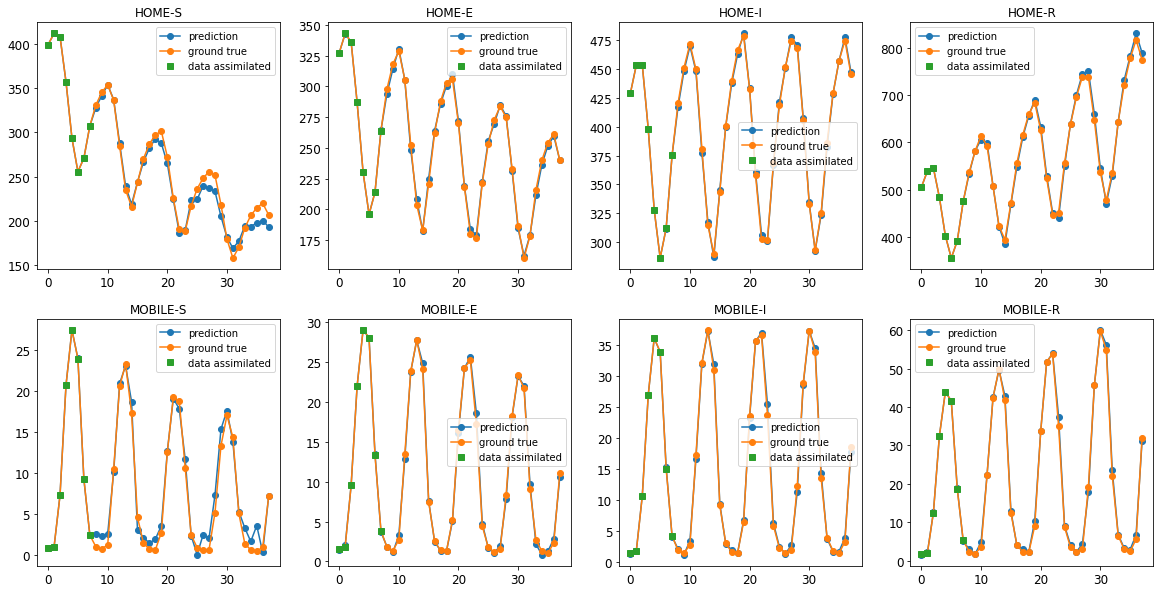

In [60]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated1[:8+30,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8+30)*step:step,i*nl*nc+4], '-o')
    ax.flatten()[i].plot(X_train_1D[n:n+(8)*step:step,i*nl*nc+4], 's')
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground true', 'data assimilated'])
#plt.savefig('GAN_generateddata.png')